In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.colors import LogNorm
import math
import pandas as pd

In [2]:
#Contour plot for beale function
def contour_beales_function():
    #plot beales function
    x, y = np.meshgrid(np.arange(-4.5, 4.5, 0.2), np.arange(-4.5, 4.5, 0.2))
    fig, ax = plt.subplots(figsize=(10, 6))
    z=beales_function(np.array([x,y]),features=0,target=0)
    cax = ax.contour(x, y, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap="RdYlBu_r")
    ax.plot(3,0.5, 'r*', markersize=18)

    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')

    ax.set_xlim((-4.5, 4.5))
    ax.set_ylim((-4.5, 4.5))
    
    return fig,ax


#Utility to plot beales contours
def plot_surface(x, y, z, azim=-60, elev=40, dist=10, cmap="RdYlBu_r", xlimL=1, xlimH=1, ylimL=1, ylimH=1, zlimL=2, zlimH=2):

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    plot_args = {'rstride': 1, 'cstride': 1, 'cmap':cmap,
             'linewidth': 20, 'antialiased': True,
             'vmin': -2, 'vmax': 2}
    ax.plot_surface(x, y, z, **plot_args)
    ax.view_init(azim=azim, elev=elev)
    ax.dist=dist
    ax.set_xlim(-xlimL, xlimH)
    ax.set_ylim(-ylimL, ylimH)
    ax.set_zlim(-zlimL, zlimH)
    
    plt.xticks([-1, -0.5, 0, 0.5, 1], ["-1", "-1/2", "0", "1/2", "1"])
    plt.yticks([-1, -0.5, 0, 0.5, 1], ["-1", "-1/2", "0", "1/2", "1"])
    ax.set_zticks([-2, -1, 0, 1, 2])
    ax.set_zticklabels(["-2", "-1", "0", "1", "2"])
    
    ax.set_xlabel("x", fontsize=18)
    ax.set_ylabel("y", fontsize=18)
    ax.set_zlabel("z", fontsize=18)
    return fig, ax;



def overlay_trajectory(ax,trajectory, label,color='k',lw=2):
    xs=trajectory[:,0]
    ys=trajectory[:,1]
    ax.plot(xs,ys, color, label=label,lw=lw)
    ax.plot(xs[-1],ys[-1],color+'>', markersize=14)
    return ax;


##Beale function

$$
z = (1.5-x+xy)^2+(2.25-x+xy^2)^2+(2.625-x+xy^3)^2
$$

With absolute minimum in 

$$(\hat{x},\hat{y})=(3,0.5)$$

In [3]:
#Beale function
def beales_function(theta,features,target):
    x=theta[0]
    y=theta[1]
    return np.square(1.5-x+x*y)+np.square(2.25-x+x*y*y)+np.square(2.625-x+x*y**3)
    

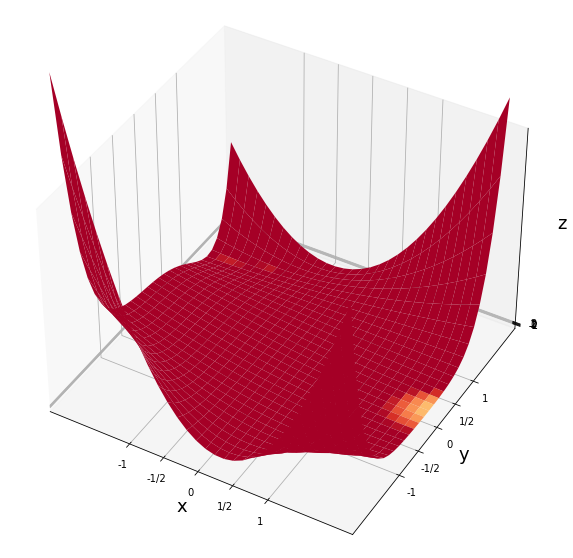

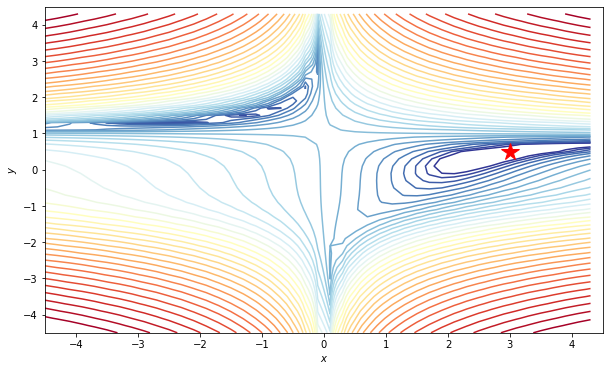

In [4]:
#Plot 3D Beale function
x, y = np.mgrid[-2:2:31j, -2:2:31j] 
fig,ax=plot_surface(x,y,beales_function(np.array([x,y]),features=0,target=0),xlimL=2.1, xlimH=2.1, ylimL=2.1, ylimH=2.1, zlimL=0,zlimH=300)

#Beale function contour plot
fig1,ax1 =contour_beales_function()
plt.show()

##PER ANIMARE IL PLOT
https://towardsdatascience.com/gradient-descent-animation-1-simple-linear-regression-e49315b24672

#Approaching Gradient Descent

##Define updating thetas functions

In [17]:
def vanilla_descent(theta,target, features,lr,loss,gradient,beta,n_iter,t, theta_p):
  
  grad=gradient(target,features,theta)
  theta=theta-lr*grad
  return [theta,0]

In [18]:
def RK_2_adaptive_gradient(theta,target, features,lr,loss,gradient,beta,n_iter,t, theta_p):
  g=gradient(target,features,theta)
  theta_hat=theta-lr*g
  g_tilde=gradient(target,features,theta_hat)
  
  prod=np.dot(np.reshape((g-g_tilde),(g.shape[0])), np.reshape((g),(g.shape[0])))
  
  tentative= 2*lr*prod/(np.linalg.norm(g-g_tilde)**2)
  if prod>0:
    lr_opt=tentative
  else:
    lr_opt=lr

  if lr_opt>=lr:
    lr=beta*lr+(1-beta)*lr_opt
  else:
    lr=(1-beta)*lr_opt
  
  theta=theta-lr*g
  
  return [theta,0]

In [19]:
def RK4(theta,target, features,lr,loss,gradient,beta,n_iter,t, theta_p): #theta=[x0,y0] 
    c =  0.003 #lr*100 #da capire come inizializzare c
    lr = (c/n_iter**(1/5))
    
    k1 = lr*gradient(target,features,theta)

    theta0 = theta - (1/2*lr*k1)
    k2=lr*gradient(target,features,theta)
    
    
    theta0 -= (1/2*lr*k2)
    k3 = lr*gradient(target,features,theta)
    
    theta0 -= (1/2*lr*k3)
    k4 = lr*gradient(target,features,theta)
    
    gradi = (k1/6 + k2/3 + k3/3 + k4/6)#*lr
    theta = theta - (gradi)
    
    return [theta,0]

In [20]:
#https://towardsdatascience.com/learning-parameters-part-2-a190bef2d12
def NAG (theta, target,features,lr,loss, gradient_f, beta, n_iter, t, theta_p): #t=a quale iterazione stiamo, theta_previous=theta_{t-1}-->s_{t-1}
    mu_s = [0.999,0.995,0.99,0.9,0] 
    mu_max = mu_s[-2]               #aumentando mu_max migliora al convergenza
    mu = min(1-2**(-1-math.log2(t/250 +1)), mu_max) #https://towardsdatascience.com/learning-parameters-part-4-6a18d1d3000b
    
    theta_a = theta - mu*theta_p
    update_t = mu * theta_p  + lr*gradient_f(target,features,theta_a)
    theta = theta - update_t
    
    return [theta, update_t]


##Define gradient function

In [21]:
def beales_gradient(target,features,theta):
  x=theta[0]
  y=theta[1]
  grad_x=2*(1.5-x+x*y)*(-1+y)+2*(2.25-x+x*y**2)*(-1+y**2)+2*(2.625-x+x*y**3)*(-1+y**3)
  grad_y=2*(1.5-x+x*y)*x+4*(2.25-x+x*y**2)*x*y+6*(2.625-x+x*y**3)*x*y**2
  grad=np.array([grad_x,grad_y])
  
  return(grad)

##Define gradient ascent function

In [22]:
def gradient_descent(theta, features, target, lr, num_steps,loss,GD_type,gradient_function,beta, n_iter,t, theta_p):
    
    loss_history = np.zeros(num_steps)
    parameter_traj=np.zeros((num_steps,theta[0].shape[0]))


    for step in range(num_steps):
        parameter_traj[step]=np.reshape(theta[0],theta[0].shape[0])
        loss_history[step]=loss(theta[0],features,target)
        theta = GD_type(theta[0], target, features, lr,loss,gradient_function,beta,n_iter,t=step, theta_p=theta[1])
        
    return theta, loss_history, parameter_traj

##Test different updating functions

# NOISE

In [23]:
#Beale function
def noisy_beales_function(theta,features,target):
    mu,var = 0,5
    x=theta[0]
    y=theta[1]
    z=np.square(1.5-x+x*y)+np.square(2.25-x+x*y*y)+np.square(2.625-x+x*y**3)
    return z + np.random.normal(mu,var,1)

In [25]:
# Initialize theta0
#inizializzazioni da dove convergiamo meglio
#[-1,-1],[3,-3],[3,3],[-1,-4]

tol=0
theta0 = [np.array([3,-2]),0]


# Run Gradient Ascent method
n_iter=100
theta_final_vanilla, log_l_history_vanilla,descent_trajectory_vanilla = gradient_descent(theta0,features=theta0,target=theta0,lr=0.0001,
                                                        num_steps=n_iter,loss=noisy_beales_function,
                                                        GD_type=vanilla_descent,gradient_function=beales_gradient,
                                                        beta=0.01,n_iter=n_iter,t=0, theta_p=0)

theta_final_NAG, log_l_history_NAG,descent_trajectory_NAG = gradient_descent(theta0,features=theta0,target=theta0,lr=0.0001,
                                                   num_steps=n_iter,loss=noisy_beales_function,
                                                   GD_type=NAG,gradient_function=beales_gradient,
                                                   beta=0.01,n_iter=n_iter,t=0, theta_p=0)

theta_final_RK4, log_l_history_RK4,descent_trajectory_RK4 = gradient_descent(theta0,features=theta0,target=theta0,lr=0.0001,
                                                   num_steps=n_iter,loss=noisy_beales_function,
                                                   GD_type=RK4,gradient_function=beales_gradient,
                                                   beta=0.01,n_iter=n_iter,t=0, theta_p=0)

theta_final_RK2, log_l_history_RK2,descent_trajectory_RK2 = gradient_descent(theta0,features=theta0,target=theta0,lr=0.0001,
                                                   num_steps=n_iter,loss=noisy_beales_function,
                                                   GD_type=RK_2_adaptive_gradient,gradient_function=beales_gradient,
                                                   beta=0.01, n_iter=n_iter,t=0, theta_p=0)

print(theta_final_RK2, theta_final_RK4, theta_final_NAG, theta_final_vanilla)


[array([2.92202188, 0.48560286]), 0] [array([2.44671571, 0.33304766]), 0] [array([ 2.51177701, -0.421304  ]), array([ 0.00162412, -0.00322695])] [array([ 2.62478728, -0.66673803]), 0]


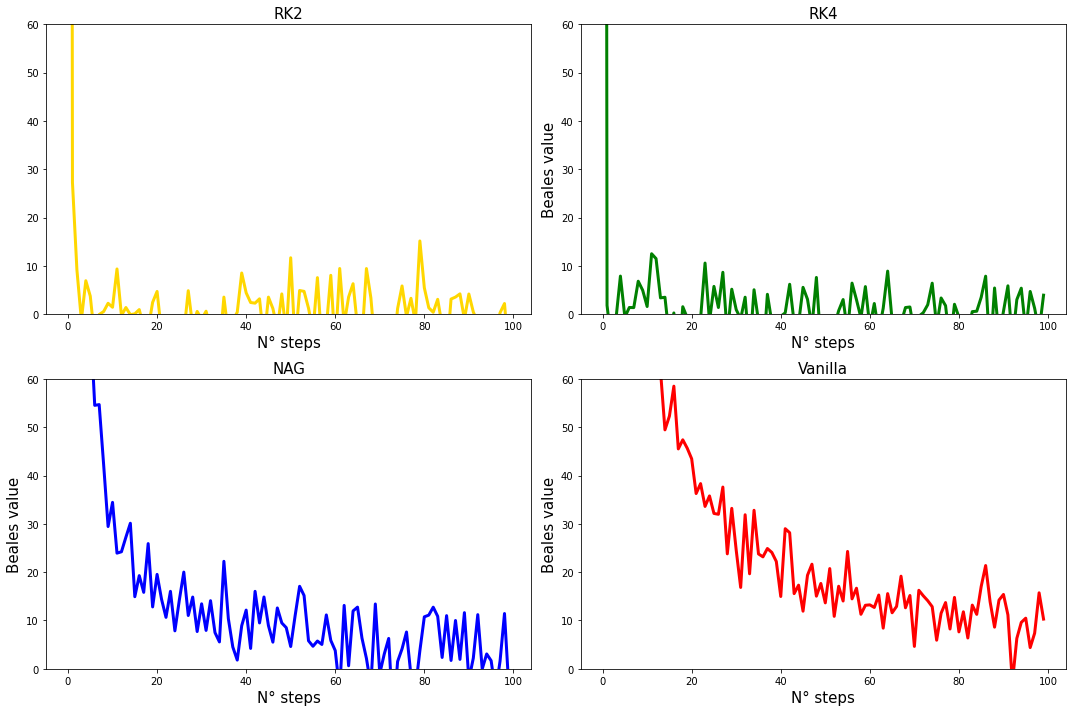

In [26]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,10))

ax1.plot(log_l_history_RK2,color="gold",linewidth=3)
ax1.set_title("RK2",fontsize=15)
ax1.set_xlabel("N° steps",fontsize=15)
ax3.set_ylabel("Beales value",fontsize=15)
ax1.set_ylim([0, 60])

ax2.plot(log_l_history_RK4,color="green",linewidth=3)
ax2.set_title("RK4",fontsize=15)
ax2.set_ylabel("Beales value",fontsize=15)
ax2.set_xlabel("N° steps",fontsize=15)
ax2.set_ylim([0, 60])

ax3.plot(log_l_history_NAG,color="blue",linewidth=3)
ax3.set_title("NAG",fontsize=15)
ax3.set_ylabel("Beales value",fontsize=15)
ax3.set_xlabel("N° steps",fontsize=15)
ax3.set_ylim([0, 60])

ax4.plot(log_l_history_vanilla,color="red",linewidth=3)
ax4.set_title("Vanilla",fontsize=15)
ax4.set_xlabel("N° steps",fontsize=15)
ax4.set_ylabel("Beales value",fontsize=15)
ax4.set_ylim([0, 60])

fig.tight_layout()


plt.show()

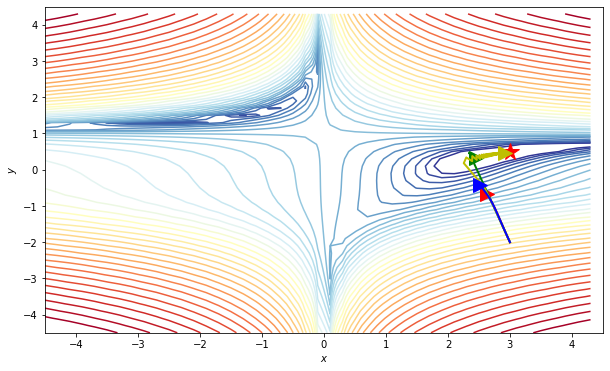

In [27]:
fig1, ax1=contour_beales_function()
overlay_trajectory(ax1,descent_trajectory_vanilla, 'Vanilla','r')
overlay_trajectory(ax1,descent_trajectory_RK4, 'RK','g')
overlay_trajectory(ax1,descent_trajectory_RK2, 'RK','y')
overlay_trajectory(ax1,descent_trajectory_NAG, 'NAG','b')

plt.show()



RISULTATI PER NOISE = 5 (MU=0,SIGMA=5), NSTEPS=100, PUNTO DI PARTENZA (3,-2) ---> METODI RK2 E 4 (SOPRATTUTTO 2) MOLTO + noise consistent perchè si avvicinano al minimo già alle prime iterazioni

# Studio rate convergenza

In [28]:
def vanilla_descent(theta,target, features,lr,loss,gradient,beta,n_iter,t, theta_p,tol):
  
  grad=gradient(target,features,theta)
  theta=theta-lr*grad
  return [theta,0]

In [29]:
def RK_2_adaptive_gradient(theta,target, features,lr,loss,gradient,beta,n_iter,t, theta_p,tol):
  g=gradient(target,features,theta)
  theta_hat=theta-lr*g
  g_tilde=gradient(target,features,theta_hat)
  
  prod=np.dot(np.reshape((g-g_tilde),(g.shape[0])), np.reshape((g),(g.shape[0])))
  
  tentative= 2*lr*prod/(np.linalg.norm(g-g_tilde)**2)
  if prod>0:
    lr_opt=tentative
  else:
    lr_opt=lr

  if lr_opt>=lr:
    lr=beta*lr+(1-beta)*lr_opt
  else:
    lr=(1-beta)*lr_opt
  
  theta=theta-lr*g
  
  return [theta,0]

In [30]:
def RK4(theta,target, features,lr,loss,gradient,beta,n_iter,t, theta_p,tol): #theta=[x0,y0] 
    c =  0.003 #lr*100 #da capire come inizializzare c
    lr = (c/n_iter**(1/5))
    
    k1 = lr*gradient(target,features,theta)

    theta0 = theta - (1/2*lr*k1)
    k2=lr*gradient(target,features,theta)
    
    
    theta0 -= (1/2*lr*k2)
    k3 = lr*gradient(target,features,theta)
    
    theta0 -= (1/2*lr*k3)
    k4 = lr*gradient(target,features,theta)
    
    gradi = (k1/6 + k2/3 + k3/3 + k4/6)#*lr
    theta = theta - (gradi)
    
    return [theta,0]

In [31]:
#https://towardsdatascience.com/learning-parameters-part-2-a190bef2d12
def NAG (theta, target,features,lr,loss, gradient_f, beta, n_iter, t, theta_p,tol): #t=a quale iterazione stiamo, theta_previous=theta_{t-1}-->s_{t-1}
    mu_s = [0.999,0.995,0.99,0.9,0] 
    mu_max = mu_s[-2]               #aumentando mu_max migliora al convergenza
    mu = min(1-2**(-1-math.log2(t/250 +1)), mu_max) #https://towardsdatascience.com/learning-parameters-part-4-6a18d1d3000b
    
    theta_a = theta - mu*theta_p
    update_t = mu * theta_p  + lr*gradient_f(target,features,theta_a)
    theta = theta - update_t
    
    return [theta, update_t]


In [32]:
def check_interval(theta, tolerance): 
    min=np.array([3,0.5])
    x=theta[0]
    y=theta[1]
    if (min[0]-tolerance <= x <= min[0]+tolerance) and (min[1]-tolerance <= y <= min[1]+tolerance):
        return True
    else:
        return False
                 

In [81]:
def gradient_descent(theta, features, target, lr, num_steps,loss,GD_type,gradient_function,beta, n_iter,t, theta_p,tolerance):
    
    loss_history = np.zeros(num_steps)
    parameter_traj=np.zeros((num_steps,theta[0].shape[0]))

    nsteps=0
    check=False
    first=0
    for step in range(num_steps):
        check=check_interval(theta[0],tolerance)
        if check==True and first ==0:
            print(('converged in {} steps for dradient method = {}').format(nsteps,str(GD_type)))
            first+=1
        parameter_traj[step]=np.reshape(theta[0],theta[0].shape[0])
        loss_history[step]=loss(theta[0],features,target)
        theta = GD_type(theta[0], target, features, lr,loss,gradient_function,beta,n_iter,step, theta[1],tolerance)
        nsteps+=1
        
    if first==0:
        print('convergence failed... :(')
        
    return theta, loss_history, parameter_traj

In [85]:
# Initialize theta0
#inizializzazioni da dove convergiamo meglio
#[-1,-1],[3,-3],[3,3],[-1,-4]

tol = 0.3
theta0 = [np.array([3,-2]),0]


# Run Gradient Ascent method
n_iter=1000
theta_final_vanilla, log_l_history_vanilla,descent_trajectory_vanilla = gradient_descent(theta0,features=theta0,target=theta0,lr=0.0001,
                                                        num_steps=n_iter,loss=beales_function,
                                                        GD_type=vanilla_descent,gradient_function=beales_gradient,
                                                        beta=0.01,n_iter=n_iter,t=0, theta_p=0,tolerance=tol)
print(theta_final_vanilla)

theta_final_NAG, log_l_history_NAG,descent_trajectory_NAG = gradient_descent(theta0,features=theta0,target=theta0,lr=0.0001,
                                                   num_steps=n_iter,loss=beales_function,
                                                   GD_type=NAG,gradient_function=beales_gradient,
                                                   beta=0.01,n_iter=n_iter,t=0, theta_p=0,tolerance=tol)
print(theta_final_NAG)

theta_final_RK4, log_l_history_RK4,descent_trajectory_RK4 = gradient_descent(theta0,features=theta0,target=theta0,lr=0.0001,
                                                   num_steps=n_iter,loss=beales_function,
                                                   GD_type=RK4,gradient_function=beales_gradient,
                                                   beta=0.01,n_iter=n_iter,t=0, theta_p=0,tolerance=tol)
print(theta_final_RK4)
      
theta_final_RK2, log_l_history_RK2,descent_trajectory_RK2 = gradient_descent(theta0,features=theta0,target=theta0,lr=0.0001,
                                                   num_steps=n_iter,loss=beales_function,
                                                   GD_type=RK_2_adaptive_gradient,gradient_function=beales_gradient,
                                                   beta=0.01, n_iter=n_iter,t=0, theta_p=0,tolerance=tol)

print(theta_final_RK2)


convergence failed... :(
[array([2.31201536, 0.02969974]), 0]
convergence failed... :(
[array([2.4818097 , 0.33765421]), array([-0.00036041, -0.00013793])]
convergence failed... :(
[array([2.5556536 , 0.36513249]), 0]
converged in 25 steps for dradient method = <function RK_2_adaptive_gradient at 0x7f810477e670>
[array([2.99999901, 0.49999976]), 0]


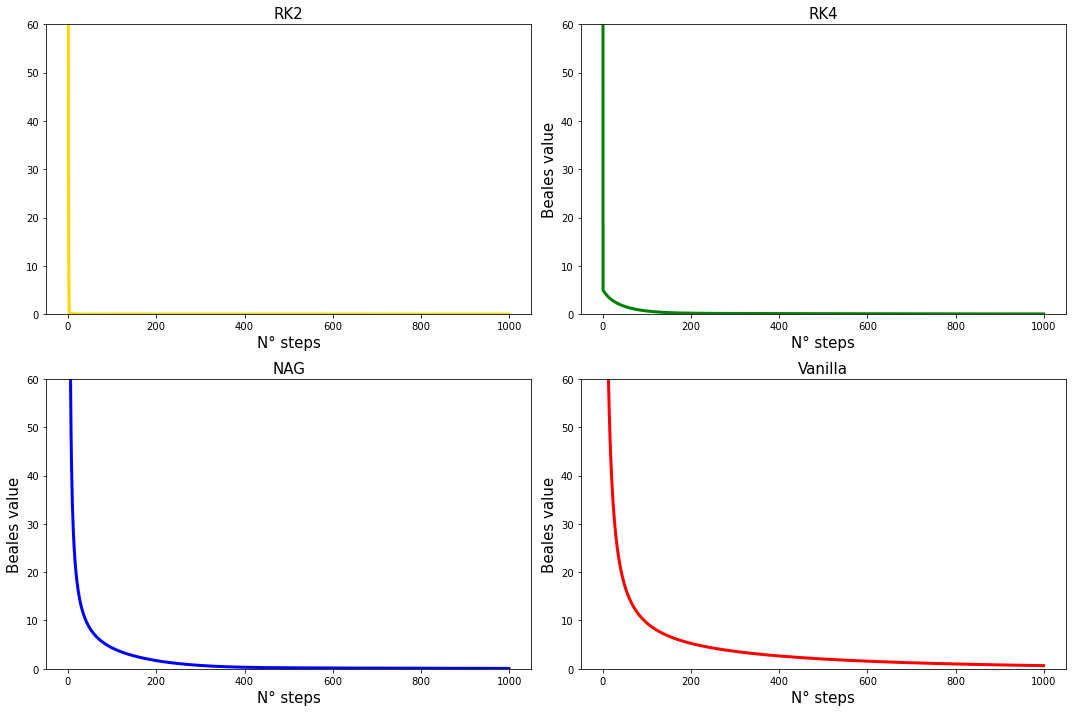

In [86]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,10))

ax1.plot(log_l_history_RK2,color="gold",linewidth=3)
ax1.set_title("RK2",fontsize=15)
ax1.set_xlabel("N° steps",fontsize=15)
ax3.set_ylabel("Beales value",fontsize=15)
ax1.set_ylim([0, 60])

ax2.plot(log_l_history_RK4,color="green",linewidth=3)
ax2.set_title("RK4",fontsize=15)
ax2.set_ylabel("Beales value",fontsize=15)
ax2.set_xlabel("N° steps",fontsize=15)
ax2.set_ylim([0, 60])

ax3.plot(log_l_history_NAG,color="blue",linewidth=3)
ax3.set_title("NAG",fontsize=15)
ax3.set_ylabel("Beales value",fontsize=15)
ax3.set_xlabel("N° steps",fontsize=15)
ax3.set_ylim([0, 60])

ax4.plot(log_l_history_vanilla,color="red",linewidth=3)
ax4.set_title("Vanilla",fontsize=15)
ax4.set_xlabel("N° steps",fontsize=15)
ax4.set_ylabel("Beales value",fontsize=15)
ax4.set_ylim([0, 60])

fig.tight_layout()


plt.show()

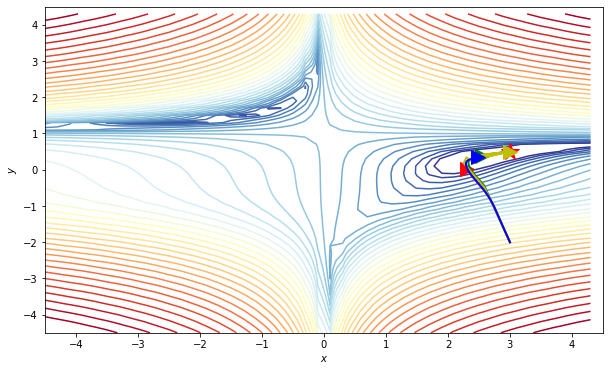

In [87]:
fig1, ax1=contour_beales_function()
overlay_trajectory(ax1,descent_trajectory_vanilla, 'Vanilla','r')
overlay_trajectory(ax1,descent_trajectory_RK4, 'RK','g')
overlay_trajectory(ax1,descent_trajectory_RK2, 'RK','y')
overlay_trajectory(ax1,descent_trajectory_NAG, 'NAG','b')

plt.show()

